In [9]:
#Imports
import torch
import pandas as pd
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch import nn
import matplotlib.pyplot as plt
import time

<h3>Config for model

In [10]:
positive_sample_size = 500
negative_sample_size = 500
positive_test_sample_size = 100
negative_test_sample_size = 100
window_size = 3
embedding_size = 5
num_epochs = 1
batch_size = 50
hidden_layer_size = 500
hidden_layer_size_2 = 100
with_attention = True
learning_rate = 0.01

<h3>Loading data for basic model

In [11]:
positive_data = pd.read_csv('positive_sample.txt', header = None, nrows = positive_sample_size)
positive_data.columns = ["Gene"]
negative_data = pd.read_csv('negative_sample.txt', header = None, nrows = negative_sample_size)
negative_data.columns = ["Gene"]
positive_test_data = pd.read_fwf('positive_sample_test.txt', header = None)
positive_test_data.columns = ["Gene"]
negative_test_data = pd.read_fwf('negative_sample_test.txt', header = None)
negative_test_data.columns = ["Gene"]
train_data = positive_data.append(negative_data)
test_data = positive_test_data.append(negative_test_data)
model_name = 'fc_with_attention.pt' if with_attention else 'fc_without_attention.pt'
#print(data.head(2))

<h3>Helper methods for the model

In [12]:
#Helper methods
def get_labels(positive_sample_size, negative_sample_size):
    #labels = []
    #positive_
    labels = torch.cat((torch.ones([positive_sample_size, 1], dtype=torch.float), torch.zeros([negative_sample_size, 1], dtype=torch.float)))
    #print(labels)
    return labels
def embeddings_helper(window_size):
    vocab_set = set()
    def generate_vocab_helper(set, k): 
        n = len(set)  
        generate_vocab(set, "", n, k) 
    def generate_vocab(set, prefix, n, k): 
        if (k == 0) : 
            vocab_set.add(prefix)
            return
        for i in range(n): 
            newPrefix = prefix + set[i] 
            generate_vocab(set, newPrefix, n, k - 1) 
    def generate_embed_map(n):
        alphabet = ['0','1','2','3','4']
        generate_vocab_helper(alphabet, n)

        vocab_set_1 = sorted(vocab_set)
        vocab_map = {}

        for i in range(len(vocab_set_1)):
            vocab_map[vocab_set_1[i]] = i
        return vocab_map
    return generate_embed_map(window_size)

def return_embeddings(vocabulary):
    embeds = nn.Embedding(len(vocabulary), embedding_size)
    embeddings = {}
    for word in vocabulary:
        embeddings[word] = embeds(torch.tensor(vocabulary[word], dtype=torch.long))
    return embeddings

#ATG, GTG, TTG
def is_start_codon(codon):
    start_codons = ['143', '343', '443']#['ATG', 'GTG', 'TTG']
    if codon in start_codons:
        return True
    return False

<h3>Create training data with training inputs and labels

In [13]:
def get_inputs_and_labels(with_attention, datapoints, positive_sample_size, negative_sample_size):
    list_of_tensors = []
    #
    # In an array, place 1s for codons that match the start pattern and 0s for codons that do not.
    #
    
    #Creating word indexes for permutations of protein bases (words of vocabulary)
    vocabulary = embeddings_helper(window_size)
    embeddings = return_embeddings(vocabulary)
    
    codon_arr = []
    for data in datapoints.itertuples():
        gene = data.Gene

        for i in range(len(gene) - window_size + 1):
            codon = gene[i:i+window_size]
            weight = 1
            if with_attention and is_start_codon(codon):
                weight = i+1
            if i == 0:
                first_tensor = embeddings[gene[i:i+window_size]] * weight
            else:
                first_tensor = torch.cat((first_tensor, weight * embeddings[gene[i:i+window_size]]), 0)

        list_of_tensors.append(first_tensor)
    inputs = torch.stack(list_of_tensors)
    labels = get_labels(positive_sample_size, negative_sample_size)
    return inputs, labels

<h3> Implementing the FC Layer

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(embedding_size*(len(positive_data.Gene[0]) - window_size + 1), hidden_layer_size)
        self.relu = F.relu
        self.sigmoid = nn.Sigmoid()
        #self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size_2)
        self.fc2 = nn.Linear(hidden_layer_size, 1)
        #self.out = nn.Linear(hidden_layer_size_2, 1)

    def forward(self, x):
        a1 = self.fc1(x)
        h1 = self.relu(a1)
        #dout = self.dout(h1)
        a2 = self.fc2(h1)
        h2 = self.relu(a2)
        #a3 = self.out(h2)
        y = self.sigmoid(h2)
        return y
    
def train_epoch(model, inputs, labels, optimizer, criterion, batch_size):
    model.train()
    #losses = []
    losses = torch.zeros(len(inputs), 1)
    labels_hat = []
    correct, wrong = 0,0
    for i in range(0, inputs.size(0)):
        #data_batch = inputs[i:i + batch_size, :]
        #labels_batch = labels[i:i + batch_size, :]
        inputs[i] = autograd.Variable(inputs[i])
        labels[i] = autograd.Variable(labels[i])

        optimizer.zero_grad()
        # (1) Forward
        label_hat = model(inputs[i])
        #print(labels_hat)
        # (2) Compute diff
        loss = criterion(label_hat, labels[i])
        # (3) Compute gradients
        #losses.append(loss.data.numpy())
        losses[i] = loss
        loss.backward(retain_graph = True)
        # (4) update weights
        optimizer.step()        
        
#         print(loss)
#         print('>>>>>')
        #get_accuracy(labels_hat)
        correct, wrong = get_train_accuracy(label_hat, len(labels_hat), len(labels), correct, wrong)
        #labels_hat.append(label_hat)
        #labels_hat = torch.cat(labels_hat, labels_hat_batch)
        

    #print('labels_hat size>', len(labels_hat))
    loss = sum(losses)/len(losses)
    
    return loss, labels_hat, tuple((correct, wrong))
    
def train_model(model, inputs, labels, optimizer, criterion, with_attention, batch_size):
    losses = []
    labels_hat = []
    print('Training the model:')
    start_time = time.time()
    accuracies = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        loss, labels_hat, acc = train_epoch(model, inputs, labels, optimizer, criterion, batch_size)

        losses.append(loss)
        #labels_hat.append(label_hat)
        #accuracy
        accuracy = 100*(acc[0]/(acc[0]+acc[1]))
        accuracies.append(accuracy)
        print('Accuracy for epoch', epoch, ' is: ', accuracy)
#         if epoch % 25 == 0:    #print every 25 mini-batches
#             print('[%d, %5d] loss: %.9f' %
#                 (epoch + 1, epoch + 1, running_loss/len(inputs)))
#             #running_loss = 0.0
    
    torch.save(model.state_dict(), model_name)
    print('Finished. Training took %.3f' %((time.time() - start_time)/60), 'minutes.')
    return losses, accuracies

In [27]:
def train():
    fcNet = Net()
    inputs, labels = get_inputs_and_labels(with_attention, train_data, positive_sample_size, negative_sample_size)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(fcNet.parameters(), lr=0.01, momentum=0.0)
    losses, train_accuracies = train_model(fcNet, inputs, labels, optimizer, criterion, with_attention, batch_size)
    if losses != None:
        plt.plot(losses)
        title = 'Loss vs Epochs for: ' + (str)(positive_sample_size + negative_sample_size) + ' data points and ' + (str)(num_epochs) + ' epochs'
        plt.title(title)
    return train_accuracies
        
        
def test():
    model = Net()
    model.load_state_dict(torch.load(model_name))
    model.eval()

    test_inputs, test_labels = get_inputs_and_labels(with_attention, test_data, positive_sample_size, negative_sample_size)
    test_labels_hat = model(test_inputs)
    accuracy = get_test_accuracy(test_labels_hat)
    print('Accuracy is: ' , accuracy)
    return accuracy
#    print(correct, wrong)
    
def get_train_accuracy(label, index, data_size, correct, wrong):    
    if index < data_size/2+1:
        if label > 0.5:
            correct += 1
        else:
            wrong += 1
    else:
        if label > 0.5:
            wrong += 1
        else:
            correct += 1
    return correct, wrong

def get_test_accuracy(labels_hat):
    #print('Length of labels_hat:', len(labels_hat))
    correct, wrong = 0, 0
    #if labels_hat
    for i in range(len(labels_hat)//2 + 1):
        if labels_hat[i] > 0.5:
            correct += 1
        else:
            wrong += 1
    for i in range(len(labels_hat)//2 + 1, len(labels_hat)):
        if labels_hat[i] > 0.5:
            wrong += 1
        else:
            correct += 1
    accuracy = 100 * (correct/(correct+wrong))
    return accuracy




************************************************************************************************************

Training the model:
Accuracy for epoch 0  is:  49.9
Finished. Training took 18.110 minutes.
Accuracy is:  49.833333333333336


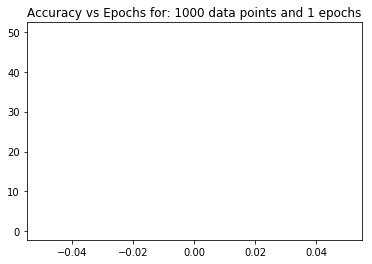

In [28]:
train_accuracies = train()
if train_accuracies != None:
    plt.plot(train_accuracies)
    title = 'Accuracy vs Epochs for: ' + (str)(positive_sample_size+negative_sample_size) + ' data points and ' + (str)(num_epochs) + ' epochs'
    plt.title(title)
test_accuracy = test()

************************************************************************************************************

In [ ]:
set_hyperparameters(3, 1000, 50, 0.01)
#net = Net()
train()
test()